In [104]:
import pickle
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

## Loading data into pandas dataframe

In [105]:
with open('datasets/final_project_dataset.pkl') as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame(data_dict).transpose()
df = df.replace({"NaN":np.nan})
df.reset_index(inplace=True)
df.rename(index=str, columns={"index": "name"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 0 to 145
Data columns (total 22 columns):
name                         146 non-null object
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null bool
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with

## Preprocessing the data
1. Fix Mis-alignment
2. Outlier removal
3. Feature operations
    - Feature selection 
    - Filling missing values
    - Feature scaling
    - Engineering new feature

### 1. Fix Mis-alignment

In [106]:
### Adjusting the Mis-aligned columns
###     8  : 'BELFER ROBERT'
###     11 : 'BHATNAGAR SANJAY'
FINANCE_COLS = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', \
                'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 'exercised_stock_options',\
                'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
df.loc[['8'], FINANCE_COLS] = \
[0, 0, 0, -102500, 0,0,0,3285,102500,3285,0,44093,-44093,0]

df.loc[['11'], FINANCE_COLS] = \
[0, 0, 0, 0, 0,0,0,137864,0,137864,15456290,2604490,-2604490,15456290]

### Handling -ve values
df['deferred_income'] = df['deferred_income']*(-1)
df['restricted_stock_deferred'] = df['restricted_stock_deferred']*(-1)

### 2. Remove outliers

In [107]:
### Removing Outliers
###      78 : 'LAVORATO JOHN J'    ~ Non-poi Has maximum bonus received
###     127 : 'THE TRAVEL AGENCY IN THE PARK'
###     130 : 'TOTAL'

df.drop(['78','127','130'], inplace=True)

### 3. Feature operations

In [108]:
### Fill missing values with 0
df.fillna(0.0, inplace=True)

### Scale the email features
from_poi_scaled = df['from_poi_to_this_person']/df['to_messages']
to_poi_scaled = df['from_this_person_to_poi']/df['from_messages']
shared_receipt_with_poi_scaled = df['shared_receipt_with_poi']/df['to_messages']
df['poi_interactions'] = from_poi_scaled + to_poi_scaled + shared_receipt_with_poi_scaled
df.fillna(0.0, inplace=True)

### Preprocess 'poi' column
df.loc[df['poi'] == True, 'poi_code'] = 1
df.loc[df['poi'] == False, 'poi_code'] = 0

### Drop unnecessary columns
drop_list = ['director_fees', 'name', 'loan_advances', 'shared_receipt_with_poi', 'to_messages', 
             'email_address', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
            'restricted_stock_deferred', 'poi']
df.drop(drop_list, axis=1, inplace=True)

### Split Features and Labels
features = df.drop('poi_code', axis=1).values
labels = df['poi_code'].values


### Scale the Features
scale = StandardScaler()
features = scale.fit_transform(features)

In [109]:
# df.describe()

In [110]:
# df

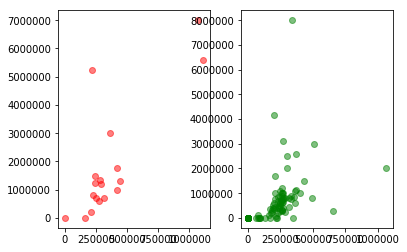

In [111]:
df['salary'].fillna(df['salary'].median(), inplace=True)
df['bonus'].fillna(df['bonus'].median(), inplace=True)
df_poi = df[df['poi_code'] == 1]
df_non = df[df['poi_code'] == 0]
plt.subplot(121)
plt.scatter(df_poi['salary'].values, df_poi['bonus'].values, color='r', alpha=0.5)
plt.subplot(122)
plt.scatter(df_non['salary'].values, df_non['bonus'].values, color='g', alpha=0.5)
plt.show()

In [112]:
# df_poi

In [113]:
### Split training and test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create the model
clf = GaussianNB()

In [114]:
### Format in which the perfromance metrics will be printed
PERF_FORMAT_STRING = "\
\nAccuracy: {:>0.{display_precision}f}\nPrecision: {:>0.{display_precision}f}\n\
Recall: {:>0.{display_precision}f}\nF1: {:>0.{display_precision}f}\nF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\nTotal predictions: {:4d}\nTrue positives: {:4d}\nFalse positives: {:4d}\n\
False negatives: {:4d}\nTrue negatives: {:4d}"

### Perfrom cross validation
def test_classifier(clf, features, labels, folds=1000):

	cv = StratifiedShuffleSplit(n_splits=folds, random_state = 42)
	true_negatives = 0
	false_negatives = 0
	true_positives = 0
	false_positives = 0
	for train_idx, test_idx in cv.split(features, labels): 
	    features_train = []
	    features_test  = []
	    labels_train   = []
	    labels_test    = []
	    for ii in train_idx:
	        features_train.append( features[ii] )
	        labels_train.append( labels[ii] )
	    for jj in test_idx:
	        features_test.append( features[jj] )
	        labels_test.append( labels[jj] )
	    
	    ### fit the classifier using training set, and test on test set
	    clf.fit(features_train, labels_train)
	    predictions = clf.predict(features_test)
	    for prediction, truth in zip(predictions, labels_test):
	        if prediction == 0 and truth == 0:
	            true_negatives += 1
	        elif prediction == 0 and truth == 1:
	            false_negatives += 1
	        elif prediction == 1 and truth == 0:
	            false_positives += 1
	        elif prediction == 1 and truth == 1:
	            true_positives += 1
	        else:
	            print "Warning: Found a predicted label not == 0 or 1."
	            print "All predictions should take value 0 or 1."
	            print "Evaluating performance for processed predictions:"
	            break
	try:
	    total_predictions = true_negatives + false_negatives + false_positives + true_positives
	    accuracy = 1.0*(true_positives + true_negatives)/total_predictions
	    precision = 1.0*true_positives/(true_positives+false_positives)
	    recall = 1.0*true_positives/(true_positives+false_negatives)
	    f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
	    f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
	    print ""
	    print clf
	    print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
	    print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
	    print ""
	    return accuracy
	except:
	    print "Got a divide by zero when trying out:", clf
	    print "Precision or recall may be undefined due to a lack of true positive predicitons."
	    return 0.0

test_classifier(clf, features, labels)



GaussianNB(priors=None)

Accuracy: 0.84287
Precision: 0.37204
Recall: 0.25950
F1: 0.30574
F2: 0.27621

Total predictions: 15000
True positives:  519
False positives:  876
False negatives: 1481
True negatives: 12124



0.8428666666666667